# Population vector analysis 

'''Created on Mon 26 April 2021'''

In this notebook we will analyze the population vector for different behaviours using the ethogram information that was extracted from DLC for once the mouse in one sessions.

Categories for different behaviours are: resting, navigation, exploring object (1 or 2) and running towards object (1 or 2). 

The experiment runs in multiple days, and we will like to see the effect of learning in the population vector for the above mentioned behaviours. Differences in population vectors will, a priori, be analyzed be computing the euclidian distance between those vectors. (THINK ABOUT HOW TO COMPARE FOR DIFFERENT DAYS AS DIFFERENT DAYS HAS DIFFERENT SIZE OF POP VECTOR)

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
#import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165         ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
#behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [5]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4       
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

In [6]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [7]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
conditions = labels

for day in range(len(behaviour_list)):
    events = np.array(events_day_list[day])
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])

    object_list = []
    for target in [0,1,2,3,4,5,6]:
        period1 = period
        if target == 0:
            period1 = period_resting
        object_data = []
        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        for event in events_duration:
            if event > period1:
                object_data.append(activity_list[day][:,time[i]:time[i]+period1])
            i = i + 1
        object_list.append(object_data)
    behavioural_events_days_list.append(object_list)

In [8]:
population_vector = []
for day in range(len(behaviour_list)):
    mean_over_trials_list = []
    for i in range(len(behavioural_events_days_list[day])):
        mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
        if mean_over_trials.shape:
            mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
    population_vector.append(mean_over_trials_list)

In [9]:
## compute euclidean distance matrix using normalization
euclidean_distance_list = []
euclidean_distance_list_z = []
for day in range(len(behaviour_list)):
    euclidean_distance = np.zeros((len(population_vector[day]),len(population_vector[day])))
    for i in range(0,len(population_vector[day])):
        for j in range(0,len(population_vector[day])):
            distance = np.linalg.norm(population_vector[day][i]-population_vector[day][j])
            euclidean_distance[i,j]= distance / population_vector[day][i].shape
    distance_mean = np.mean(euclidean_distance[np.triu_indices_from(euclidean_distance, k=1)])
    distance_std = np.std(euclidean_distance[np.triu_indices_from(euclidean_distance, k=1)])
    euclidean_distance_z_score =(euclidean_distance - distance_mean) / distance_std
    euclidean_distance_list_z.append(euclidean_distance_z_score)
    euclidean_distance_list.append(euclidean_distance)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


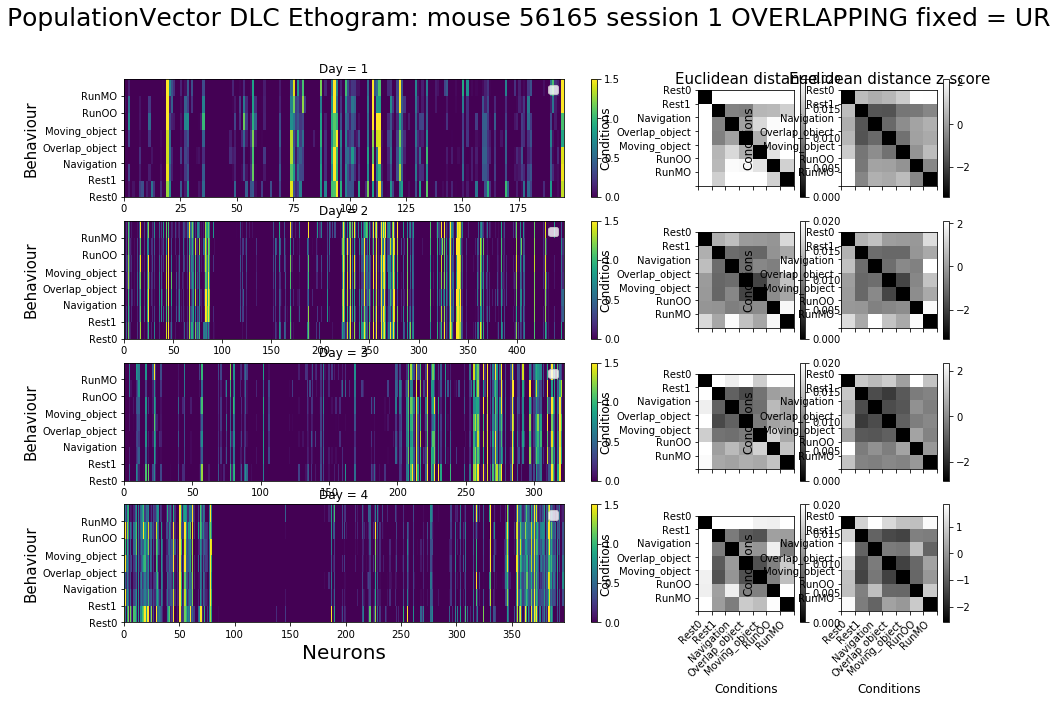

In [10]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


fig = plt.figure()
gs = plt.GridSpec(len(behaviour_list), 6)

vmin= 0
vmax=0.02

vmin_corr = 0
vmax_corr = 1.5

for day in range(len(behaviour_list)):
    ax = fig.add_subplot(gs[day, 0:4])
    
    #for j in range(len(population_vector[day])):
        #ax.plot(population_vector[day][j])
        #ax.plot(population_vector[day][1])
        #ax.plot(population_vector[day][2])
    mesh = ax.pcolormesh(population_vector[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    x_pos = np.arange(0,len(conditions))
    ax.set_yticks(x_pos)
    ax.set_yticklabels(conditions)
    
    ax.legend(conditions, fontsize = 12)
    if day == len(behaviour_list)-1:
        ax.set_xlabel('Neurons', fontsize = 20)
    ax.set_ylabel('Behaviour', fontsize = 15)
    ax.set_title('Day = ' + f'{day+1}')
    
    
    ax1 = fig.add_subplot(gs[day, 4])
    if day == 0:
        ax1.set_title('Euclidean distance', fontsize = 15)
    x = ax1.imshow(euclidean_distance_list[day], cmap = 'gray')
    #x = ax.pcolormesh(euclidean_distance_list[day], cmap = 'gray')
    x.set_clim(vmin,vmax)
    
    x_pos = np.arange(-0.5,len(conditions)+0.5)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(conditions)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([])
    if day == len(behaviour_list)-1:
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(conditions)
        ax1.set_xlabel('Conditions', fontsize = 12)
    ax1.set_ylabel('Conditions', fontsize = 12)
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.colorbar(x, ax=ax1)
    
    ax1 = fig.add_subplot(gs[day, 5])
    if day == 0:
        ax1.set_title('Euclidean distance z-score', fontsize = 15)
    x = ax1.imshow(euclidean_distance_list_z[day], cmap = 'gray')
    #x = ax.pcolormesh(euclidean_distance_list[day], cmap = 'gray')
    #x.set_clim(vmin,vmax)
    
    x_pos = np.arange(-0.5,len(conditions)+0.5)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(conditions)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([])
    if day == len(behaviour_list)-1:
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(conditions)
        ax1.set_xlabel('Conditions', fontsize = 12)
    ax1.set_ylabel('Conditions', fontsize = 12)
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.colorbar(x, ax=ax1)
    


    
fig.tight_layout()
fig.set_size_inches(15,10)
#fig.suptitle('Population Vector differences: ' + task + ' fixed = ' + fixed  , fontsize = 25)
fig.suptitle('PopulationVector DLC Ethogram: mouse '+f'{mouse}'+' session '+f'{session}' +' '+ task + ' fixed = ' + fixed  , fontsize = 25)

#figure_name = figure_path +'population_vector_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

figure_name = figure_path +'population_vector_DLCevents_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

fig.savefig(figure_name)

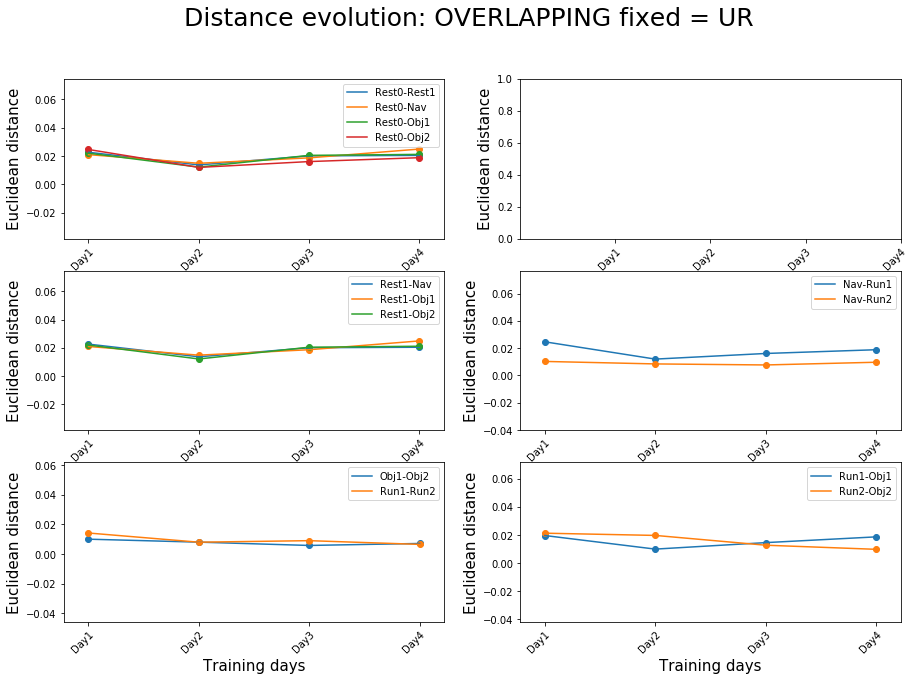

In [11]:
## plot evolution of euclidean distance in multiple days

evolution = np.zeros((4,13))
for day in range(len(euclidean_distance_list)):
    evolution[day][0] = euclidean_distance_list[day][0,1]
    evolution[day][1] = euclidean_distance_list[day][0,2]
    evolution[day][2] = euclidean_distance_list[day][0,3]
    evolution[day][3] = euclidean_distance_list[day][0,4]    
    
    evolution[day][4] = euclidean_distance_list[day][1,2]
    evolution[day][5] = euclidean_distance_list[day][1,3]
    evolution[day][6] = euclidean_distance_list[day][1,4]
    
    evolution[day][7] = euclidean_distance_list[day][2,5]
    evolution[day][8] = euclidean_distance_list[day][2,6] 
    
    evolution[day][9] = euclidean_distance_list[day][3,4]
    evolution[day][10] = euclidean_distance_list[day][5,6]
    
    evolution[day][11] = euclidean_distance_list[day][3,5]
    evolution[day][12] = euclidean_distance_list[day][4,6]

condition0 = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2'] 
condition1 = ['Rest1-Nav','Rest1-Obj1','Rest1-Obj2'] 
condition2 = ['Nav-Run1', 'Nav-Run2']
condition3 = ['Obj1-Obj2','Run1-Run2']
condition4 = ['Run1-Obj1','Run2-Obj2']
              
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(3,2)

for i in range(4):
    axes[0,0].scatter([1,2,3,4],evolution[:,i])
    axes[0,0].plot([1,2,3,4],evolution[:,i])   
axes[0,0].legend(condition0)

for i in range(3):
    axes[1,0].scatter([1,2,3,4],evolution[:,i])
    axes[1,0].plot([1,2,3,4],evolution[:,i])   
axes[1,0].legend(condition1)

for i in range(3,5):
    axes[1,1].scatter([1,2,3,4],evolution[:,i])
    axes[1,1].plot([1,2,3,4],evolution[:,i]) 
axes[1,1].legend(condition2)

for i in range(5,7):
    axes[2,0].scatter([1,2,3,4],evolution[:,i])
    axes[2,0].plot([1,2,3,4],evolution[:,i]) 
axes[2,0].legend(condition3)

for i in range(7,9):
    axes[2,1].scatter([1,2,3,4],evolution[:,i])
    axes[2,1].plot([1,2,3,4],evolution[:,i]) 
axes[2,1].legend(condition4)

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlabel('Training days', fontsize = 15)
        axes[i,j].set_ylabel('Euclidean distance', fontsize = 15)
        x_pos = np.arange(1,5)
        #axes[i,j].set_ylim([0, 0.05])
        axes[i,j].set_xticks(x_pos)
        axes[i,j].set_xticklabels(x_axes)
        plt.setp(axes[i,j].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
              
#fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('Distance evolution: ' + task + ' fixed = ' + fixed  , fontsize = 25)
#fig.suptitle('Distance evolution_inspection: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

#figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_inspection.png'

fig.savefig(figure_name)

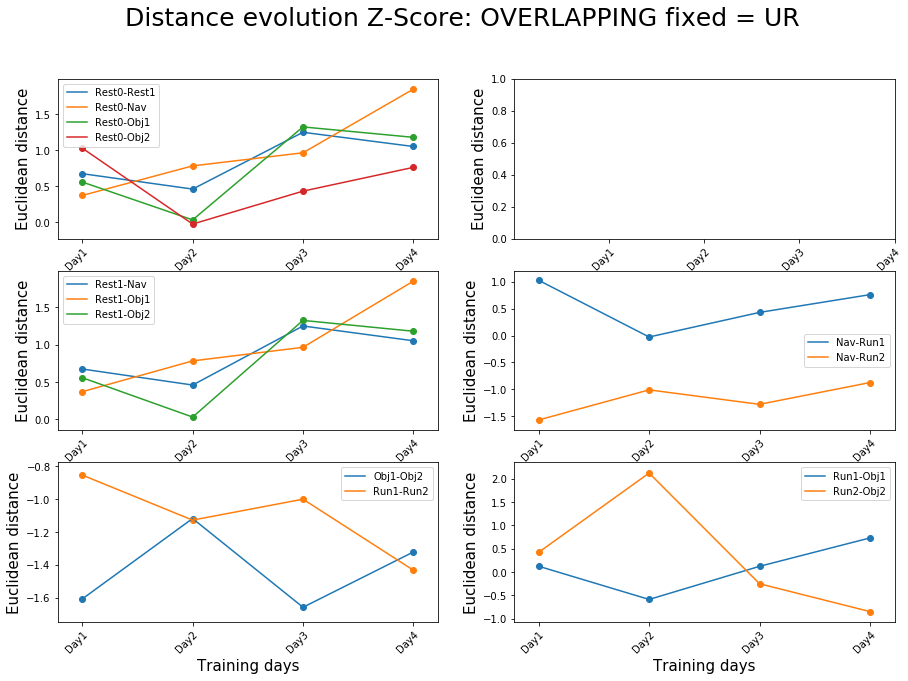

In [12]:
## plot evolution of euclidean distance in multiple days

evolution = np.zeros((4,13))
for day in range(len(euclidean_distance_list)):
    evolution[day][0] = euclidean_distance_list_z[day][0,1]
    evolution[day][1] = euclidean_distance_list_z[day][0,2]
    evolution[day][2] = euclidean_distance_list_z[day][0,3]
    evolution[day][3] = euclidean_distance_list_z[day][0,4]    
    
    evolution[day][4] = euclidean_distance_list_z[day][1,2]
    evolution[day][5] = euclidean_distance_list_z[day][1,3]
    evolution[day][6] = euclidean_distance_list_z[day][1,4]
    
    evolution[day][7] = euclidean_distance_list_z[day][2,5]
    evolution[day][8] = euclidean_distance_list_z[day][2,6] 
    
    evolution[day][9] = euclidean_distance_list_z[day][3,4]
    evolution[day][10] = euclidean_distance_list_z[day][5,6]
    
    evolution[day][11] = euclidean_distance_list_z[day][3,5]
    evolution[day][12] = euclidean_distance_list_z[day][4,6]

condition0 = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2'] 
condition1 = ['Rest1-Nav','Rest1-Obj1','Rest1-Obj2'] 
condition2 = ['Nav-Run1', 'Nav-Run2']
condition3 = ['Obj1-Obj2','Run1-Run2']
condition4 = ['Run1-Obj1','Run2-Obj2']
              
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(3,2)

for i in range(4):
    axes[0,0].scatter([1,2,3,4],evolution[:,i])
    axes[0,0].plot([1,2,3,4],evolution[:,i])   
axes[0,0].legend(condition0)

for i in range(3):
    axes[1,0].scatter([1,2,3,4],evolution[:,i])
    axes[1,0].plot([1,2,3,4],evolution[:,i])   
axes[1,0].legend(condition1)

for i in range(3,5):
    axes[1,1].scatter([1,2,3,4],evolution[:,i])
    axes[1,1].plot([1,2,3,4],evolution[:,i]) 
axes[1,1].legend(condition2)

for i in range(5,7):
    axes[2,0].scatter([1,2,3,4],evolution[:,i])
    axes[2,0].plot([1,2,3,4],evolution[:,i]) 
axes[2,0].legend(condition3)

for i in range(7,9):
    axes[2,1].scatter([1,2,3,4],evolution[:,i])
    axes[2,1].plot([1,2,3,4],evolution[:,i]) 
axes[2,1].legend(condition4)

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlabel('Training days', fontsize = 15)
        axes[i,j].set_ylabel('Euclidean distance', fontsize = 15)
        x_pos = np.arange(1,5)
        
        #axes[i,j].set_ylim([0, 0.05])
        axes[i,j].set_xticks(x_pos)
        axes[i,j].set_xticklabels(x_axes)
        plt.setp(axes[i,j].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
              
#fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('Distance evolution Z-Score: ' + task + ' fixed = ' + fixed  , fontsize = 25)
#fig.suptitle('Distance evolution_inspection: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'distance_evolution_ZSCORE_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

#figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_inspection.png'

fig.savefig(figure_name)